
# Robot Hút Bụi với A* (kèm BFS/DFS/Dijkstra so sánh hiệu năng)

Áp dụng thuật toán A* cho robot hút bụi trên ma trận `A_{m,n}`, robot có thể **Move** (8 hướng) và **Suck**.  
- Mỗi **Move** tốn chi phí `1`.  
- **Sau mỗi hành động** (Move/Suck), **mỗi ô còn bẩn** tăng thêm `+1` vào chi phí dọn sạch của riêng ô đó.  
- Người dùng được phép: chỉ định kích thước ma trận và số lượng ô bẩn (random).  
- Hiển thị: lộ trình di chuyển của robot và **tổng chi phí**.  
- Cấu trúc lớp theo đề (có thể mở rộng):

```python
class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Cell:
    def __init__(self, position:(), parent:(), status, g, h, f):
        self.position = position      # (x, y)
        self.parent   = parent        # parent (object) in a path
        self.status   = status        # {'free','start','dirty','clean'}
        self.g        = g             # current cost
        self.h        = h             # estimated cost
        self.f        = f             # full path cost
```

### Diễn giải về chi phí "tăng dần" cho các ô bẩn
- Gọi một **bước** là một hành động của robot (Move hoặc Suck).
- Sau mỗi bước, **mỗi ô bẩn còn lại** cộng thêm `+1` vào **chi phí dọn** của chính ô đó.
- Khi robot **Suck** tại một ô bẩn, chi phí dọn của ô đó chính là **số bước** đã trôi qua trước thời điểm dọn.
- Tổng chi phí kế hoạch = **Tổng chi phí Move** (mỗi lần = 1) **+** **tổng chi phí dọn của tất cả ô bẩn** (bằng tổng thời điểm dọn của từng ô).  
  > Tương đương với: sau **mỗi bước**, cộng thêm số ô bẩn **còn lại** (penalty), cộng với 1 nếu bước đó là Move.

Notebook này cài đặt **A*** (tối ưu theo chi phí trên) và bổ sung **BFS/DFS/Dijkstra** để so sánh **thời gian chạy, số node mở rộng, độ dài kế hoạch, tổng chi phí**.


In [ ]:
from typing import Callable, Dict, Iterable, List, Sequence, Tuple
import random
import time
import math
import heapq
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

random.seed(42)
np.random.seed(42)


In [ ]:
#-------------------------------------------------------------------------------
# Lớp biểu diễn các toạ độ (x, y)
#-------------------------------------------------------------------------------
class Position:
    """
    Đại diện cho một tọa độ trên lưới/hệ trục 2D.

    Parameters
    ----------
    x : int
        Hoành độ (cột) hoặc trục X của điểm.
    y : int
        Tung độ (hàng) hoặc trục Y của điểm.

    Notes
    -----
    - Lớp này chỉ là "value object" nhỏ gọn để gom cặp (x, y) lại,
      giúp code dễ đọc hơn so với dùng tuple rời rạc.
    - Không bao gồm logic tính toán; mọi phép xử lý (khoảng cách, láng giềng, ...)
      nên được đặt ở nơi khác (utils/helper) để giữ lớp này thuần dữ liệu.
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

#-------------------------------------------------------------------------------
# Lớp biểu diễn các ô
#-------------------------------------------------------------------------------
class Cell:
    """
    Đại diện cho một ô (node) trên lưới.

    Parameters
    ----------
    position : Position
        Tọa độ của ô. Truyền đối tượng `Position` được định nghĩa ở trên.
    parent : Optional["Cell"]
        Ô cha trong đường đi (pointer ngược để lần vết đường đi sau khi tìm xong).
        - `None` nếu ô là điểm bắt đầu (không có cha) hoặc chưa được nối vào đường đi.
    status :
        Trạng thái ngữ nghĩa của ô trong bài toán:
        - "free"  : ô rảnh, có thể đi qua.
        - "start" : điểm xuất phát.
        - "dirty" : ô bẩn (cần dọn trong bài toán robot hút bụi).
        - "clean" : ô đã sạch (hoặc đã được xử lý).
    g : float
        Chi phí thực tế đã đi từ điểm bắt đầu đến ô này (đã biết).
        Trong A*: đây là "cost-so-far".
    h : float
        Chi phí ước lượng từ ô này đến đích (heuristic). Ví dụ: Manhattan/Euclidean.
    f : float
        Tổng chi phí đánh giá của ô: `f = g + h`.
        - Trong A*, dùng `f` để ưu tiên mở rộng ô có tổng chi phí nhỏ nhất.
        - Trong Dijkstra, `h` = 0 nên `f` ≡ `g`.

    Notes
    -----
    - `parent` dùng để tái tạo đường đi; giúp tránh quay lại ngay ô vừa đến
        (tối ưu trong một số triển khai).
    - Tính `h` (heuristic). Điều kiện:
        1) Không vượt quá chi phí thật (admissible),
        2) Thỏa điều kiện tam giác (consistent) để tối ưu.
    """
    def __init__(self, position:(), parent:(), status, g, h, f):
        self.position = position  # (x, y)
        self.parent   = parent    # parent (object) in a path
        self.status   = status    # {'free','start','dirty','clean'}
        self.g        = g         # current cost
        self.h        = h         # estimated cost
        self.f        = f         # full path cost

In [ ]:

#-------------------------------------------------------------------------------
# Lớp ma trận các tiện ích
#-------------------------------------------------------------------------------
MOVES_8 = [(-1,-1), (-1,0), (-1,1),
           ( 0,-1),         ( 0,1),
           ( 1,-1), ( 1,0), ( 1,1)]

class Grid:
    """
    Lưới (m x n) các ô `Cell` phục vụ các thuật toán tìm đường/robot hút bụi.

    Hệ quy chiếu & indexing
    -----------------------
    - Tọa độ dạng (x, y) với:
      - x: cột, 0 ở mép trái, tăng dần sang phải (0 <= x < n)
      - y: hàng, 0 ở mép dưới, tăng dần từ dưới lên trên (0 <= y < m)
    - Truy cập phần tử: `self.cells[y][x]` (hàng trước, cột sau).
    - `start` và các phần tử trong `dirty_positions` đều dùng cùng hệ quy chiếu.

    Parameters
    ----------
    m : int
        Số hàng của lưới (chiều cao).
    n : int
        Số cột của lưới (chiều rộng).
    dirty_positions : Iterable[Tuple[int, int]]
        Danh sách/tập hợp các tọa độ ô bẩn cần dọn.
    start : Tuple[int, int]
        Tọa độ ô bắt đầu.

    Attributes
    ----------
    m : int
        Số hàng.
    n : int
        Số cột.
    cells : List[List[Cell]]
        Ma trận 2D `Cell` kích thước m x n, khởi tạo trạng thái `'free'`.
    start : Position(x, y)
        Vị trí bắt đầu (được gán trạng thái `'start'` trên lưới).
    dirty_set : Set[Position(x, y)]
        Tập các vị trí bẩn. Nếu `start` nằm trong danh sách bẩn truyền vào thì
        sẽ bị loại ra, tránh trùng trạng thái.

    Notes
    -----
    - Mặc định mọi ô khởi tạo có `status='free'` và chi phí g=h=f=0.
    - Sau khởi tạo:
        + Ô `start` có `status='start'`.
        + Các ô trong `dirty_positions` (trừ `start`) có `status='dirty'`.
    """
    def __init__(self, m, n, dirty_positions, start):
        self.m = m
        self.n = n
        self.cells = [[Cell(Position(x, y), None, 'free', 0, 0, 0) for x in range(n)] for y in range(m)]
        self.start = start
        self.dirty_set = set(dirty_positions)
        if start in self.dirty_set:
            self.dirty_set.remove(start)

        # Khởi tạo lưới ô Cell (m hàng x n cột), tất cả mặc định 'free'
        # Lưu ý: Indexed theo cells[y][x]
        self.cells[start[1]][start[0]].status = 'start'
        for (dx, dy) in dirty_positions:
            if (dx, dy) != start:
                self.cells[dy][dx].status = 'dirty'

    def in_bounds(self, x, y):
        """
        Kiểm tra (x, y) có nằm trong biên lưới hay không.

        Returns
        -------
        bool
            True nếu 0 <= x < n và 0 <= y < m, ngược lại False.
        """
        return 0 <= x < self.n and 0 <= y < self.m

    def neighbors(self, x, y):
        """
        Sinh ra các láng giềng 8 hướng của ô (x, y) nằm trong biên lưới.

        Yields
        ------
        Tuple[int, int]
            Mỗi lần yield là một tọa độ láng giềng hợp lệ (nx, ny).

        Notes
        -----
        - Sử dụng `MOVES_8` (Moore neighborhood).
        - Không kiểm tra va chạm/chướng ngại; chỉ kiểm biên.
        """
        for dx, dy in MOVES_8:
            nx, ny = x + dx, y + dy
            if self.in_bounds(nx, ny):
                yield (nx, ny)

    def status(self, x, y):
        """
        Lấy trạng thái (`status`) của ô tại (x, y).

        Returns
        -------
        Literal['free', 'start', 'dirty', 'clean']
            Trạng thái hiện tại của ô.
        """
        return self.cells[y][x].status

    def set_status(self, x, y, s):
        """
        Gán trạng thái (`status`) cho ô tại (x, y).

        Parameters
        ----------
        x, y : int
            Tọa độ ô cần cập nhật.
        s : Literal['free', 'start', 'dirty', 'clean']
            Trạng thái mới cần gán.
        """
        self.cells[y][x].status = s

# --- Metrics ---
def chebyshev(a, b):
    """
    Khoảng cách Chebyshev giữa hai điểm a và b trong lưới ô vuông.

    Công dụng
    ---------
    - Phù hợp khi cho phép di chuyển 8 hướng (bao gồm chéo) với chi phí đơn vị.
    - Trong A* với di chuyển 8 hướng và chi phí đồng nhất, Chebyshev là heuristic
      *admissible* và *consistent*.

    Parameters
    ----------
    a, b : Position(x, y)

    Returns
    -------
    int
        Giá trị khoảng cách Chebyshev.
    """
    return max(abs(a[0]-b[0]), abs(a[1]-b[1]))

def manhattan(a, b) -> int:
    dx, dy = abs(a[0]-b[0]), abs(a[1]-b[1])
    return dx + dy

def euclid(a, b) -> float:
    dx, dy = abs(a[0]-b[0]), abs(a[1]-b[1])
    return (dx*dx + dy*dy) ** 0.5

def octile(a, b) -> float:
    # 8 hướng với cost chéo = sqrt(2), thẳng = 1
    dx, dy = abs(a[0]-b[0]), abs(a[1]-b[1])
    m = min(dx, dy); M = max(dx, dy)
    return (M - m) + m * math.sqrt(2.0)


In [ ]:

def plot_grid(grid, path, title="Path"):
    """
    Vẽ lưới (grid) m×n, tô màu các ô 'dirty' và 'start', vẽ mũi tên thể hiện đường đi.

    Coordinate system & indexing
    ----------------------------
    - Tọa độ logic của lưới là (x, y) với x: cột (0..n-1), y: hàng (0..m-1), gốc (0,0) ở **góc dưới-trái**.

    Parameters
    ----------
    grid : object
        Đối tượng lưới có thuộc tính:
          - m, n : kích thước (số hàng, số cột)
          - status(x, y) : trả về trạng thái tại (x, y) ∈ {'free','start','dirty','clean'}
    path : List[Position(x,y)]
        Danh sách các điểm (x, y) theo thứ tự đi qua. Mỗi cặp liên tiếp sẽ được nối bằng mũi tên.
    title : str, optional
        Tiêu đề của biểu đồ.

    Rendering details
    -----------------
    - Lưới: vẽ bằng các `Rectangle` 1×1, viền xám, không tô (fill=False).
    - Ô 'dirty': tô nền cyan; ô 'start': tô nền xanh lá.
    - Đường đi: dùng `plt.arrow` vẽ từ tâm ô i đến gần tâm ô i+1 (scale 0.85 để chừa chỗ cho mũi tên).
      * head_width=0.15: độ rộng đầu mũi tên
      * length_includes_head=True: chiều dài vector có tính cả phần đầu mũi tên
      * color='blue': màu mũi tên

    Notes
    -----
    - Hàm đặt aspect='equal' để ô vuông không bị méo.
    - Tắt lưới mặc định của matplotlib (`plt.grid(False)`) vì đã tự vẽ lưới bằng Rectangle.
    """
    m, n = grid.m, grid.n
    plt.figure(figsize=(6, 6))

    # Vẽ khung lưới bằng các hình chữ nhật không tô màu
    for y in range(m):
        for x in range(n):
            rect = plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='gray')
            plt.gca().add_patch(rect)

    # Tô màu các ô theo status ('dirty' và 'start')
    for y in range(m):
        for x in range(n):
            st = grid.status(x, y)
            if st == 'dirty':
                rect = plt.Rectangle((x, y), 1, 1, facecolor='cyan', fill=True, edgecolor='gray')
                plt.gca().add_patch(rect)
            if st == 'start':
                rect = plt.Rectangle((x, y), 1, 1, facecolor='green', fill=True, edgecolor='gray')
                plt.gca().add_patch(rect)

    # Vẽ mũi tên dọc theo path
    #    - Lấy tâm ô: (x + 0.5, y + 0.5)
    #    - Nhân 0.85 để mũi tên không chạm sát rìa ô đích (đẹp hơn, thấy đầu mũi tên rõ ràng)
    for i in range(len(path)-1):
        x1, y1 = path[i]
        x2, y2 = path[i+1]

        # Tâm ô nguồn sau khi transform y
        px1, py1 = x1 + 0.5, (y1) + 0.5
        px2, py2 = x2 + 0.5, (y2) + 0.5

        # Vector dịch chuyển
        dx, dy = px2 - px1, py2 - py1

        # Tham số của plt.arrow:
        # - (px1, py1): điểm bắt đầu
        # - (dx*0.85, dy*0.85): vector (delta x, delta y) đã scale
        # - head_width: độ rộng đầu mũi tên
        # - length_includes_head: tính cả đầu mũi tên vào chiều dài vector
        plt.arrow(px1, py1, dx*0.85, dy*0.85, head_width=0.15, length_includes_head=True, color='blue')

    # Cấu hình trục/tỷ lệ
    plt.xlim(0, n)
    plt.ylim(0, m)
    plt.xticks(range(n+1))
    plt.yticks(range(m+1))
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(False)

    # Thêm legend
    legend_patches = [
    mpatches.Patch(color='cyan', label='dirty'),
    mpatches.Patch(color='green', label='start')
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.show()


In [ ]:

class ProblemEncoder:
    """
    Bộ mã hoá/bài toán cho môi trường robot-hút-bụi trên lưới.

    Ý tưởng chính
    -------------
    - Trạng thái được mã hoá thành bộ 3: (x, y, mask)
        * (x, y): vị trí hiện tại của robot trên lưới.
        * mask: bitmask kích thước K (K = số ô bẩn). Bit i = 1 nếu ô bẩn,
          ngược lại 0 nếu đã sạch.
    - Tập hành động:
        * ('suck', (x, y)): hút bẩn tại vị trí hiện tại (nếu đây là ô bẩn).
        * ('move', (nx, ny)): di chuyển sang láng giềng hợp lệ (do Grid cung cấp).
    - Chi phí bước (step_cost):
        * Hút: 1 + penalty, với penalty = số ô bẩn còn lại SAU khi hút.
        * Di chuyển: 1 + penalty, với penalty = số ô bẩn còn lại TRƯỚC khi di chuyển.
      Một dạng "cost shaping": khuyến khích dọn sớm (vì penalty phụ thuộc
      số ô bẩn còn lại), đồng thời không làm thay đổi mục tiêu cuối là dọn sạch.

    Yêu cầu `grid`
    --------------
    - Thuộc tính: `m`, `n`, `start`.
    - Phương thức:
        * `neighbors(x, y)` -> Iterable[Position(x,y)]

    Thuộc tính
    ----------
    grid : Grid
        Lưới làm môi trường.
    m, n : int
        Kích thước lưới (hàng, cột).
    dirty_positions : List[Tuple[int, int]]
        Danh sách toạ độ các ô bẩn (thứ tự trong list xác định thứ tự bit).
    index_by_pos : Dict[Position(x,y), int]
        Ánh xạ toạ độ ô bẩn -> chỉ số bit trong mask.
    K : int
        Số ô bẩn.
    """
    def __init__(self, grid, dirty_positions):
        self.grid = grid
        self.m = grid.m
        self.n = grid.n

        # Danh sách ô bẩn và ánh xạ vị trí -> index bit
        self.dirty_positions = list(dirty_positions)
        self.index_by_pos = {pos:i for i, pos in enumerate(self.dirty_positions)}
        self.K = len(self.dirty_positions)

    # ---------------------------
    # Bitmask
    # ---------------------------
    def pos_to_index(self, pos):
        """
        Trả về chỉ số bit của ô bẩn `pos`, hoặc None nếu `pos` không phải ô bẩn.
        """
        return self.index_by_pos.get(pos, None)

    def set_bit(self, mask, idx):
        """
        Đặt bit thứ `idx` về 1 (đánh dấu "còn bẩn").
        """
        return mask | (1 << idx)

    def clear_bit(self, mask, idx):
        """
        Xoá bit thứ `idx` (về 0) để đánh dấu ô bẩn thứ `idx` đã được làm sạch.
        """
        return mask & ~(1 << idx)

    def is_dirty(self, mask, idx):
        """
        Kiểm tra bit thứ `idx` trong `mask` (1 nếu còn bẩn, 0 nếu đã sạch).
        Trả về 0/1 (int) để có thể dùng trực tiếp trong điều kiện.
        """
        return (mask >> idx) & 1

    def dirty_count(self, mask):
        """
        Đếm số ô bẩn còn lại (số bit 1) trong `mask`.
        """
        return bin(mask).count("1")

    # ---------------------------
    # State & transitions
    # ---------------------------
    def initial_state(self):
        """
        Tạo trạng thái ban đầu: robot ở `grid.start`, tất cả ô bẩn đều đang bẩn (mask = all-ones).
        Returns
        -------
        (x0, y0, mask): State
        """
        x0, y0 = self.grid.start
        mask = 0
        # Gán 1 cho tất cả K bit bẩn (tức "còn bẩn")
        for i, pos in enumerate(self.dirty_positions):
            mask = self.set_bit(mask, i)
        return (x0, y0, mask)

    def actions(self, state):
        """
        Sinh danh sách hành động hợp lệ tại trạng thái `state`.

        Quy tắc
        -------
        - Nếu đang đứng trên một ô được đánh dấu bẩn trong `mask`, thêm hành động ('suck', (x, y)).
        - Cho phép di chuyển tới mọi láng giềng mà `grid.neighbors(x, y)` trả về.

        Returns
        -------
        List[Action]
        """
        x, y, mask = state
        actions = []

        # Hút nếu ô hiện tại thuộc tập bẩn và bit tương ứng đang bật (1)
        idx = self.pos_to_index((x, y))
        if idx is not None and self.is_dirty(mask, idx):
            actions.append(('suck', (x, y)))

        # Di chuyển đến các láng giềng (định nghĩa bởi Grid)
        for nx, ny in self.grid.neighbors(x, y):
            actions.append(('move', (nx, ny)))

        return actions

    def step(self, state, action):
        """
        Thực hiện 1 bước chuyển trạng thái theo hành động.

        Chi phí
        -------
        - 'suck': step_cost = 1 + penalty, với penalty = số ô bẩn còn lại **sau** khi hút.
        - 'move': step_cost = 1 + penalty, với penalty = số ô bẩn còn lại **trước** khi di chuyển.

        Returns
        -------
        (new_state, step_cost)
        """
        x, y, mask = state
        name, param = action

        if name == 'suck':
            # Hút: xoá bit nếu (x,y) là ô bẩn
            idx = self.pos_to_index((x, y))
            new_mask = self.clear_bit(mask, idx) if idx is not None else mask

            # Penalty theo số ô bẩn còn lại sau hút
            penalty = self.dirty_count(new_mask)
            step_cost = 1 + penalty
            return (x, y, new_mask), step_cost

        else:
            # Di chuyển: không đổi mask
            nx, ny = param

            # Penalty theo số ô bẩn còn lại trước khi di chuyển
            penalty = self.dirty_count(mask)
            step_cost = 1 + penalty
            return (nx, ny, mask), step_cost

    def goal_test(self, state):
        """
        Kiểm tra điều kiện đích: tất cả ô bẩn đã sạch (mask == 0).
        """
        return state[2] == 0


In [ ]:

def mst_lower_bound(points, distance_func):
    """
    Tính **cận dưới MST (Minimum Spanning Tree)** trên tập điểm cho trước
    bằng khoảng cách Chebyshev. Đây là biến thể đơn giản của Prim (O(k^2)).

    Ý tưởng
    -------
    - Với một tập k điểm (các "dirty cells"), chi phí của **cây khung nhỏ nhất** (MST)
      là cận dưới cho mọi hành trình đi qua tất cả các điểm đó (ví dụ TSP hoặc
      bài toán dọn sạch nhiều điểm), vì mọi hành trình liên thông đều phải "bao"
      một cây khung.
    - Dùng khoảng cách Chebyshev vì môi trường của ta cho phép di chuyển 8 hướng
      với chi phí đơn vị (Chebyshev là metric phù hợp và thỏa tam giác).

    Parameters
    ----------
    points : Sequence[Tuple[int,int]]
        Danh sách tọa độ các điểm cần kết nối.
    distance_func: Các cách tính khoảng cách giữa hai điểm.

    Returns
    -------
    int
        Tổng trọng số của MST theo khoảng cách Chebyshev.
        Trả về 0 nếu #points ≤ 1.

    Complexity
    ----------
    - Thời gian: O(k^2) với k = len(points) (vòng lồng nhau kiểu Prim cơ bản).
    - Bộ nhớ: O(k).

    Notes
    -----
    - Hàm *không* dựng cây, chỉ trả tổng trọng số (đủ dùng cho heuristic).
    - Nếu cần tối ưu lớn k, có thể dùng heap (Prim O(k^2) → O(k^2) vẫn vậy nếu dùng ma trận
      khoảng cách; với đồ thị thưa + heap có thể O(E log V)).
    """
    if len(points) <= 1:
        return 0

    # Duy trì hai tập: in_tree (đã vào cây) & remaining (chưa duyệt)
    remaining = set(range(len(points)))
    current = next(iter(remaining)) # bắt đầu từ một đỉnh bất kỳ
    remaining.remove(current)
    in_tree = {current}

    total = 0 # tổng trọng số MST

    while remaining:
        best = None
        best_d = float('inf')

        # Tìm cạnh ngắn nhất nối từ in_tree sang một đỉnh còn lại (kiểu Prim)
        for i in in_tree:
            for j in remaining:
                d = distance_func(points[i], points[j])
                if d < best_d:
                    best_d = d
                    best = j

        # Gộp đỉnh 'best' vào cây và cộng trọng số cạnh tối ưu
        total += best_d
        in_tree.add(best)
        remaining.remove(best)
    return total

def make_heuristic(distance_func):
    """
    Tạo heuristic(state, encoder) = min_dist(robot→dirty) + MST(dirties) với khoảng cách dist_fn.
    """
    def heuristic(state, encoder: ProblemEncoder):
        """
        Heuristic cho A* trong bài toán robot hút bụi:
        h(state) = khoảng cách từ robot đến **ô bẩn gần nhất** + **MST** trên các ô bẩn còn lại.
        distance_func = cách cách tính khoảng cách

        Giải thích tính admissible/consistent (trực giác)
        -------------------------------------------------
        - `d0` = min distance từ (x,y) đến 1 trong các điểm bẩn ⇒ phải tốn ít nhất d0 bước để chạm 1 điểm bẩn.
        - `mst` = chi phí cây khung nhỏ nhất nối tất cả điểm bẩn ⇒ là cận dưới cho chi phí để "bao phủ"
        hết các điểm bẩn còn lại (mọi hành trình phải chứa một cây khung).
        - Vì Chebyshev là metric (thỏa tam giác) và h là tổng hai cận dưới độc lập,
        nên h **admissible**; trong thực tế thiết kế kiểu này cũng thường **consistent**.

        Parameters
        ----------
        state : (x, y, mask)
            Trạng thái hiện tại: vị trí robot và bitmask ô bẩn (1 = còn bẩn).
        encoder : ProblemEncoder
            Cung cấp danh sách ô bẩn (`dirty_positions`) và helpers (is_dirty).

        Returns
        -------
        int
            Giá trị heuristic không vượt quá chi phí thực (cận dưới).
        """
        x, y, mask = state

        # Nếu không còn ô bẩn → heuristic = 0
        if mask == 0:
            return 0

        # Liệt kê các ô bẩn còn lại theo mask (giữ đúng thứ tự/định danh của encoder)
        dirties = [pos
                for i, pos in enumerate(encoder.dirty_positions)
                if encoder.is_dirty(mask, i)]

        # d0: khoảng cách gần nhất từ robot đến 1 ô bẩn
        d0 = min(distance_func((x, y), p) for p in dirties)

        # mst: cận dưới kết nối mọi ô bẩn còn lại
        mst = mst_lower_bound(dirties, distance_func)

        # Tổng hợp hai cận dưới
        return d0 + mst
    return heuristic


In [ ]:

def reconstruct_path(came_from, end_state):
    """
    Lần vết (reconstruct) đường đi từ dict `came_from` bắt đầu ở `end_state`.

    Ý tưởng
    -------
    - `came_from` là ánh xạ: state -> state_cha (được tạo trong A* / Dijkstra khi relax cạnh).
    - Bắt đầu từ `end_state`, lần ngược qua `came_from[state]` cho đến khi không còn cha (None).
    - Đảo ngược danh sách để nhận thứ tự từ đầu -> cuối.

    Parameters
    ----------
    came_from : Dict[State, Optional[State]]
        Bảng truy vết: mỗi state lưu lại state cha (hoặc None nếu là start).
    end_state : Optional[State]
        Trạng thái cuối cần lần vết (có thể None nếu không tìm được đường).

    Returns
    -------
    (path_states, path_xy) : Tuple[List[State], List[Tuple[int,int]]]
        - `path_states`: danh sách đầy đủ các trạng thái (x, y, mask) từ start đến end.
        - `path_xy`: danh sách chỉ gồm (x, y) tương ứng với mỗi trạng thái (tiện cho vẽ/hiển thị).

    Notes
    -----
    - Nếu `end_state` là None, kết quả sẽ là ([None], [(None_x, None_y)]) — nhưng trong thực tế,
      upstream nên đảm bảo chỉ gọi khi đã có nghiệm. Tuỳ bạn, có thể tự vệ: nếu `end_state` is None
      thì trả `([], [])`.
    """
    path_states = []
    cur = end_state

    # Lần ngược: end -> ... -> start (None)
    while cur is not None:
        path_states.append(cur)
        # dùng dict.get để tránh KeyError nếu state chưa từng ghi nhận cha
        cur = came_from.get(cur, None)

    # Đảo lại để có chiều start -> end
    path_states.reverse()

    # Trích riêng chuỗi (x, y) phục vụ vẽ
    path_xy = [(s[0], s[1]) for s in path_states]
    return path_states, path_xy

def compute_plan_cost(encoder, path_states):
    """
    Tính **tổng chi phí kế hoạch** theo đúng luật cost của môi trường, dựa trên chuỗi trạng thái.

    Quy ước chi phí (khớp với `ProblemEncoder.step`)
    -----------------------------------------------
    - Nếu từ `prev` sang `cur` **không đổi (x, y)** nhưng **mask thay đổi** (giảm bit bẩn) ⇒ hành động 'suck':
        step_cost = 1 + penalty, với `penalty = số ô bẩn còn lại SAU khi hút = popcount(cur.mask)`.
    - Ngược lại ⇒ hành động 'move':
        step_cost = 1 + penalty, với `penalty = số ô bẩn còn lại TRƯỚC khi di chuyển = popcount(prev.mask)`.

    Parameters
    ----------
    encoder : ProblemEncoder
        Tham chiếu chưa dùng trong tính toán hiện tại (để tương thích chữ ký,
        có thể dùng nếu sau này muốn đổi luật chi phí).
    path_states : List[State]
        Dãy trạng thái từ start đến end (đã reconstruct).

    Returns
    -------
    (cost, steps, leftovers) : Tuple[int, int, int]
        - `cost`     : tổng chi phí toàn kế hoạch.
        - `steps`    : số bước chuyển trạng thái (len(path_states) - 1).
        - `leftovers`: số ô bẩn còn lại ở trạng thái cuối (popcount(mask cuối)).

    Notes
    -----
    - Hàm này **không suy luận hành động trực tiếp** ('suck' hay 'move'), mà
      nhận biết bằng **mẫu chuyển trạng thái**:
        * 'suck': (x, y) giữ nguyên, mask giảm.
        * 'move': (x, y) đổi, mask giữ nguyên.
    - Nếu chuỗi trạng thái rỗng hoặc chỉ có 1 phần tử, `cost=steps=leftovers=0`.
    """
    if not path_states:
        return 0, 0, 0
    cost = 0
    steps = 0

    # Duyệt cặp liên tiếp (prev -> cur)
    for i in range(1, len(path_states)):
        prev = path_states[i-1]
        cur  = path_states[i]
        if prev[0] == cur[0] and prev[1] == cur[1] and prev[2] != cur[2]:
            # HÚT: vị trí giữ nguyên, mask thay đổi (set bit bằng 0)
            penalty = bin(cur[2]).count("1") # số ô bẩn còn lại SAU hút
            step_cost = 1 + penalty
        else:
            # DI CHUYỂN: vị trí thay đổi (thông thường mask giữ nguyên)
            penalty = bin(prev[2]).count("1")  # số ô bẩn còn lại TRƯỚC khi di chuyển
            step_cost = 1 + penalty

        cost += step_cost
        steps += 1

    # Số ô bẩn còn lại ở trạng thái cuối
    leftovers = bin(path_states[-1][2]).count("1")
    return cost, steps, leftovers


In [ ]:

def astar_search(encoder: ProblemEncoder, max_expansions=200000, heuristic_fn=None):
    """
    Chạy A* trên không gian trạng thái do `encoder` định nghĩa.

    Trạng thái & chi phí
    --------------------
    - State = (x, y, mask), xem `ProblemEncoder`.
    - `encoder.step(s, a)` trả về (s', step_cost) với cost shaping:
      * move: 1 + (#dirty trước khi move)
      * suck: 0 + (#dirty sau khi hút)
    - `heuristic(s, encoder)` = d0 + MST(dirties) (cận dưới).

    Chiến lược
    ----------
    - Duy trì:
      * `g_score[state]` = chi phí tốt nhất đã biết từ start đến `state`.
      * `f_score[state]` = `g_score[state] + heuristic(state)`.
      * `frontier` = min-heap theo f-score.
      * `came_from` để lần vết đường đi khi chạm goal.
    - Mỗi lần pop state có f nhỏ nhất; nếu là goal → reconstruct và trả kết quả.

    Ngắt sớm
    --------
    - Dừng khi số node mở rộng vượt `max_expansions`.

    Returns
    -------
    SearchResult
        - name        : "A*"
        - path_states : đường đi (chuỗi state) nếu có nghiệm, rỗng nếu thất bại
        - path_xy     : chuỗi (x, y) tương ứng
        - cost        : tổng chi phí kế hoạch theo `compute_plan_cost` (∞ nếu thất bại)
        - expanded    : số node đã mở rộng
        - steps       : số bước (len(path_states) - 1)
        - time_ms     : thời gian chạy (ms)
        - leftovers   : số ô bẩn còn lại ở state cuối (None nếu thất bại)
    """
    if heuristic_fn is None:
        heuristic_fn = make_heuristic(chebyshev)  # mặc định dùng chebyshev

    start = encoder.initial_state()

    frontier = []
    g_score = {start: 0}
    f0 = heuristic_fn(start, encoder)

    heapq.heappush(frontier, (f0, start))

    came_from = {start: None}
    expansions = 0
    t0 = time.time()

    while frontier:
        # Lấy node có f nhỏ nhất
        _, current = heapq.heappop(frontier)

        # Kiểm tra goal
        if encoder.goal_test(current):
            t_ms = (time.time() - t0)*1000.0
            path_states, path_xy = reconstruct_path(came_from, current)
            total_cost, steps, leftovers = compute_plan_cost(encoder, path_states)
            return {"name":"A*",
                    "path_states":path_states,
                    "path_xy":path_xy,
                    "cost":total_cost,
                    "expanded":expansions,
                    "steps":steps,
                    "time_ms":t_ms,
                    "leftovers":leftovers}

        expansions += 1
        if expansions > max_expansions:
            break

        # Mở rộng hàng xóm qua các hành động
        for action in encoder.actions(current):
            nxt, step_cost = encoder.step(current, action)

            # Relaxation: nếu g tốt hơn, cập nhật và đẩy vào heap
            tentative_g = g_score[current] + step_cost
            if tentative_g < g_score.get(nxt, float('inf')):
                came_from[nxt] = current
                g_score[nxt] = tentative_g
                f = tentative_g + heuristic_fn(nxt, encoder)
                #f_score[nxt] = f
                heapq.heappush(frontier, (f, nxt))

    # Không tìm được goal (hoặc vượt limit)
    t_ms = (time.time() - t0)*1000.0
    return {"name":"A*",
            "path_states":[],
            "path_xy":[],
            "cost":float('inf'),
            "expanded":expansions,
            "steps":0,
            "time_ms":t_ms,
            "leftovers":None}

def dijkstra_search(encoder: ProblemEncoder, max_expansions=200000):
    """
    Dijkstra: trường hợp đặc biệt của A* với heuristic ≡ 0.
    Dùng để so sánh thuật toán khi không dùng heuristic

    Khác biệt chính so với A*
    -------------------------
    - `frontier` ưu tiên theo `g_score` (chi phí thật), không cộng heuristic.
    - Phần còn lại giống A*: relaxation + came_from để reconstruct.

    Returns
    -------
    SearchResult (name="Dijkstra")
    """
    start = encoder.initial_state()

    frontier = []
    g_score = {start: 0}

    heapq.heappush(frontier, (0, start))

    came_from = {start: None}
    expansions = 0
    t0 = time.time()

    while frontier:
        cur_g, current = heapq.heappop(frontier)

        # Nếu current chính là goal → reconstruct
        if encoder.goal_test(current):
            t_ms = (time.time() - t0)*1000.0
            path_states, path_xy = reconstruct_path(came_from, current)
            total_cost, steps, leftovers = compute_plan_cost(encoder, path_states)
            return {"name":"Dijkstra",
                    "path_states":path_states,
                    "path_xy":path_xy,
                    "cost":total_cost,
                    "expanded":expansions,
                    "steps":steps,
                    "time_ms":t_ms,
                    "leftovers":leftovers}
        expansions += 1
        if expansions > max_expansions:
            break

        # Mở rộng láng giềng
        for action in encoder.actions(current):
            nxt, step_cost = encoder.step(current, action)
            tentative_g = g_score[current] + step_cost
            if tentative_g < g_score.get(nxt, float('inf')):
                came_from[nxt] = current
                g_score[nxt] = tentative_g
                heapq.heappush(frontier, (tentative_g, nxt))

    t_ms = (time.time() - t0)*1000.0
    return {"name":"Dijkstra",
            "path_states":[],
            "path_xy":[],
            "cost":float('inf'),
            "expanded":expansions,
            "steps":0,
            "time_ms":t_ms,
            "leftovers":None}

def bfs_search(encoder: ProblemEncoder, max_expansions=200000):
    """
    BFS trên không gian trạng thái (không trọng số/không dùng g-score).
    Thích hợp nếu mọi step_cost xem như bằng nhau,
    nên BFS không đảm bảo tối ưu chi phí trong môi trường cost shaping.

    Cách làm
    --------
    - Hàng đợi FIFO (`deque`).
    - `visited` để tránh lặp.
    - `came_from` để reconstruct đường đi đầu tiên chạm goal.

    Returns
    -------
    SearchResult (name="BFS")
    """
    start = encoder.initial_state()

    from collections import deque
    q = deque([start])

    came_from = {start: None}
    visited = {start}
    expansions = 0
    t0 = time.time()

    while q:
        cur = q.popleft()

        if encoder.goal_test(cur):
            t_ms = (time.time() - t0)*1000.0
            path_states, path_xy = reconstruct_path(came_from, cur)
            total_cost, steps, leftovers = compute_plan_cost(encoder, path_states)
            return {"name":"BFS",
                    "path_states":path_states,
                    "path_xy":path_xy,
                    "cost":total_cost,
                    "expanded":expansions,
                    "steps":steps,
                    "time_ms":t_ms,
                    "leftovers":leftovers}

        expansions += 1
        if expansions > max_expansions:
            break

        for action in encoder.actions(cur):
            nxt, _ = encoder.step(cur, action)
            if nxt not in visited:
                visited.add(nxt)
                came_from[nxt] = cur
                q.append(nxt)

    t_ms = (time.time() - t0)*1000.0
    return {"name":"BFS",
            "path_states":[],
            "path_xy":[],
            "cost":float('inf'),
            "expanded":expansions,
            "steps":0,
            "time_ms":t_ms,
            "leftovers":None}

def dfs_search(encoder: ProblemEncoder, max_expansions=200000):
    """
    DFS (ngăn xếp) tìm đường bất kỳ đến goal.

    Cách làm
    --------
    - Stack LIFO.
    - `visited` tránh lặp.
    - `came_from` để reconstruct đường đi khi chạm goal.

    Returns
    -------
    SearchResult (name="DFS")
    """
    start = encoder.initial_state()

    stack = [start]
    came_from = {start: None}
    visited = {start}
    expansions = 0
    t0 = time.time()

    while stack:
        cur = stack.pop()

        if encoder.goal_test(cur):
            t_ms = (time.time() - t0)*1000.0
            path_states, path_xy = reconstruct_path(came_from, cur)
            total_cost, steps, leftovers = compute_plan_cost(encoder, path_states)
            return {"name":"DFS",
                    "path_states":path_states,
                    "path_xy":path_xy,
                    "cost":total_cost,
                    "expanded":expansions,
                    "steps":steps,
                    "time_ms":t_ms,
                    "leftovers":leftovers}

        expansions += 1
        if expansions > max_expansions:
            break

        # Đưa hàng xóm chưa thăm vào stack
        for action in encoder.actions(cur):
            nxt, _ = encoder.step(cur, action)
            if nxt not in visited:
                visited.add(nxt)
                came_from[nxt] = cur
                stack.append(nxt)

    t_ms = (time.time() - t0)*1000.0
    return {"name":"DFS",
            "path_states":[],
            "path_xy":[],
            "cost":float('inf'),
            "expanded":expansions,
            "steps":0,
            "time_ms":t_ms,
            "leftovers":None}


Start: (1, 0) Dirty: [(3, 3), (2, 0)]
A* (Chebyshev) | cost     12 | steps     6 | expanded     26 | time 0.55 ms
A* (Manhattan) | cost     12 | steps     6 | expanded     21 | time 0.27 ms
A* (Euclid) | cost     12 | steps     6 | expanded     23 | time 0.26 ms
A* (Octile) | cost     12 | steps     6 | expanded     22 | time 0.28 ms
Dijkstra  | cost     12 | steps     6 | expanded     33 | time 0.40 ms
BFS       | cost     12 | steps     6 | expanded     41 | time 0.37 ms
DFS       | cost     18 | steps     8 | expanded     17 | time 0.10 ms


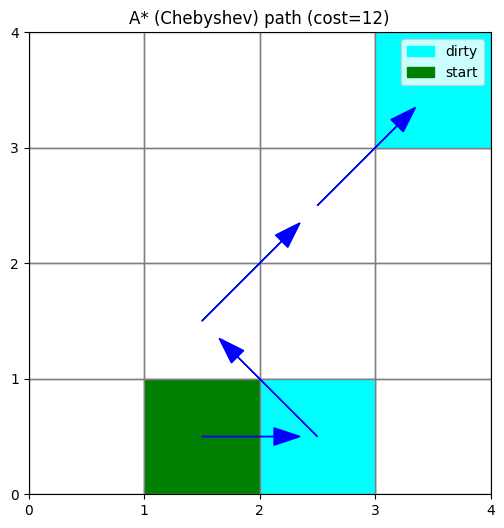

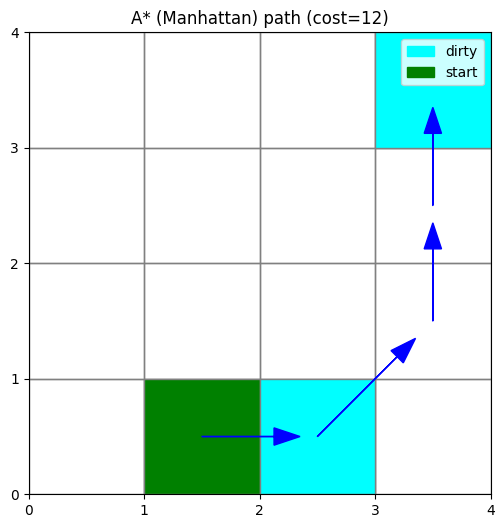

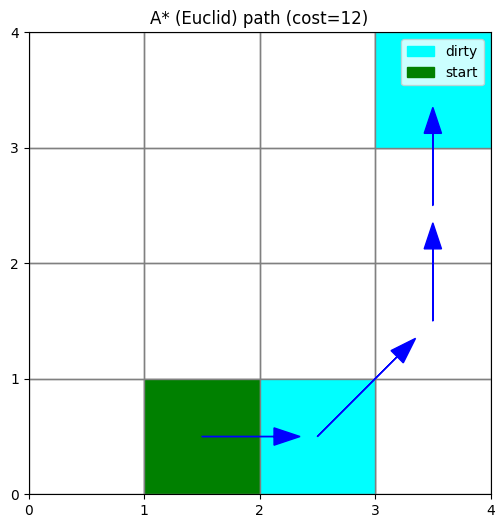

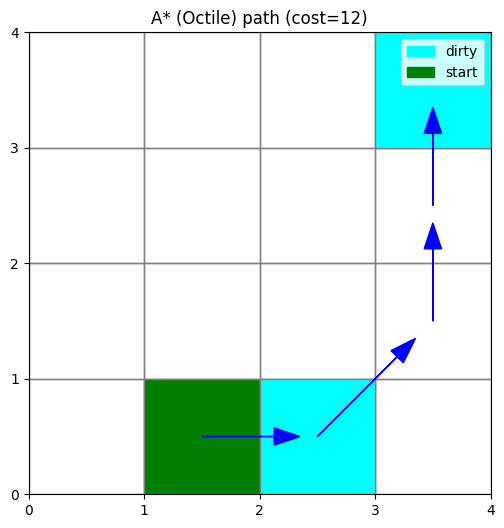

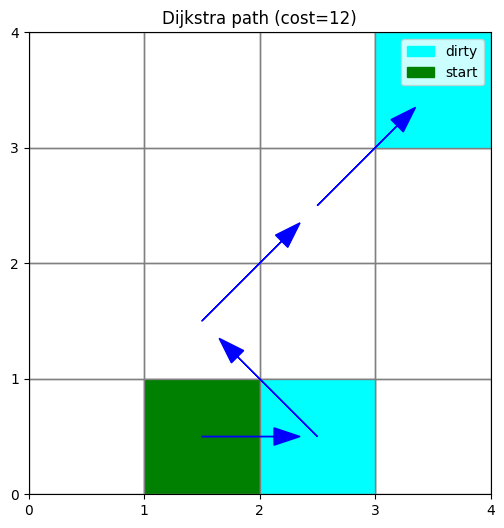

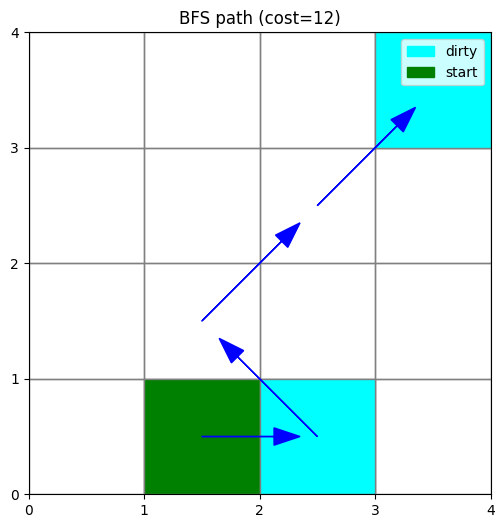

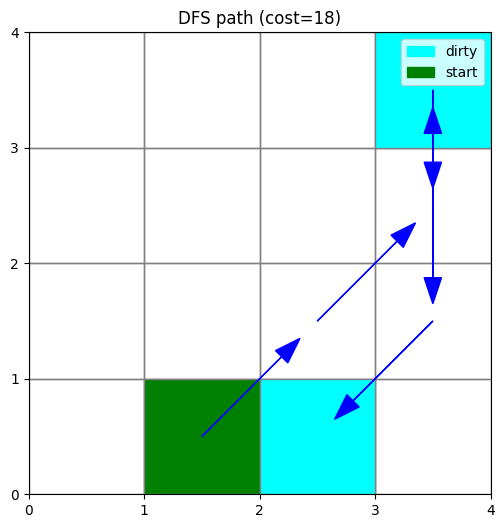

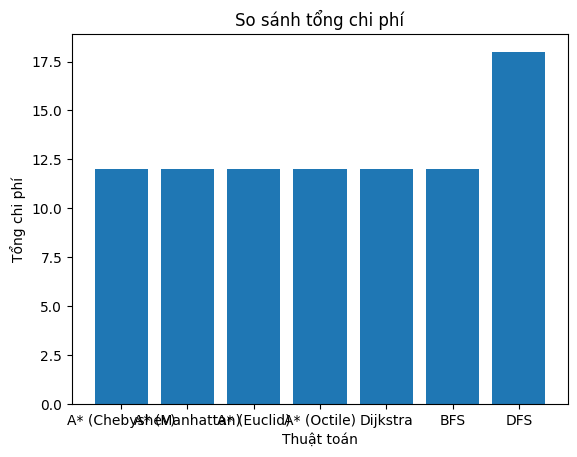

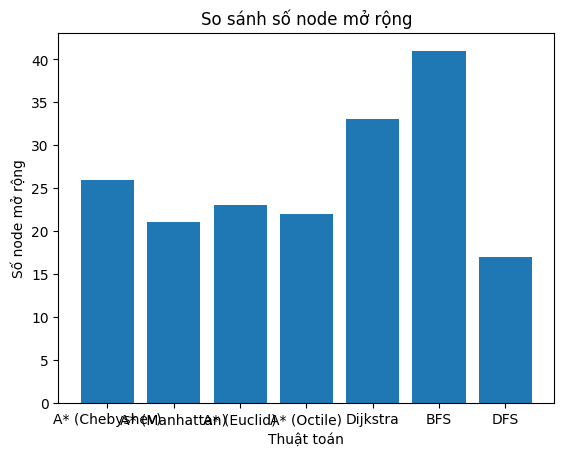

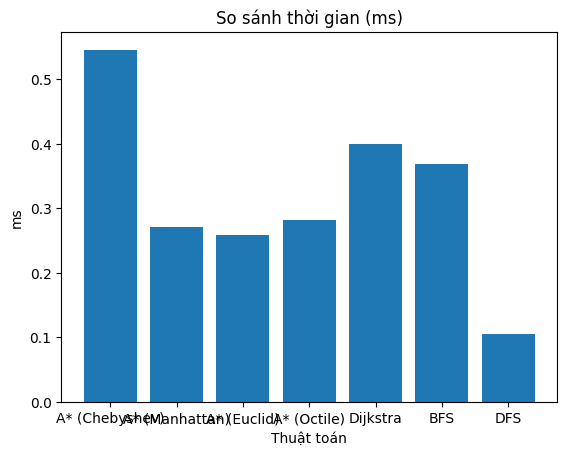

In [ ]:

def generate_random_problem(m=4, n=4, dirty_count=2, seed=0):
    """
    Sinh ngẫu nhiên một bài toán hút bụi trên lưới m×n.

    Parameters
    ----------
    m, n : int
        Kích thước lưới (m hàng, n cột).
    dirty_count : int
        Số lượng ô bẩn cần tạo ngẫu nhiên.
    seed : int
        Hạt giống (seed) để tái lập kết quả ngẫu nhiên.

    Returns
    -------
    (m, n, dirty_positions, start) : Tuple
        - m, n : kích thước lưới
        - dirty_positions : danh sách toạ độ các ô bẩn (duy nhất, không trùng nhau)
        - start : toạ độ điểm bắt đầu

    Notes
    -----
    - `start` có thể tình cờ trùng với một ô bẩn. Phần `Grid` khởi tạo sau đó
      nên tự loại `start` khỏi tập bẩn nếu bạn muốn đảm bảo "start không bẩn".
    """
    rnd = random.Random(seed)

    # Chọn một toạ độ bắt đầu ngẫu nhiên
    start = (rnd.randrange(n), rnd.randrange(m))

    # Sinh tập các ô bẩn ngẫu nhiên (dùng set để không trùng nhau)
    dirty_positions = set()
    while len(dirty_positions) < dirty_count:
        p = (rnd.randrange(n), rnd.randrange(m))
        dirty_positions.add(p)

    # Trả về cấu hình bài toán
    return m, n, list(dirty_positions), start

def run_all_algorithms(m=4, n=4, dirty_count=2, seed=0,
                       astar_heuristics: Iterable[str] = ("Chebyshev", "Manhattan", "Euclid", "Octile"),
                       visualize=True):
    """
    Nhận cấu hình từ generate_random_problem và chạy lần lượt A*, Dijkstra, BFS, DFS để so sánh.

    Quy trình
    --------
    1) Gọi `generate_random_problem` để sinh (m, n, dirties, start)
    2) Khởi tạo `Grid` và `ProblemEncoder`
    3) Chạy các thuật toán tìm đường:
       - A*
       - Dijkstra
       - BFS
       - DFS
    4) In bảng tóm tắt: chi phí, số bước, số node mở rộng, thời gian
    5) (Tuỳ chọn) Vẽ đường đi của A* nếu có nghiệm
    6) Vẽ 3 biểu đồ cột: tổng chi phí, số node mở rộng, thời gian (ms)

    Parameters
    ----------
    m, n : int
        Kích thước lưới.
    dirty_count : int
        Số ô bẩn sinh ngẫu nhiên.
    seed : int
        Hạt giống ngẫu nhiên để tái lập thí nghiệm.
    visualize : bool
        True để trực quan hoá đường đi của A* (nếu có).

    Returns
    -------
    results : List[dict]
        Danh sách kết quả theo từng thuật toán, gồm các khoá:
        ['name', 'path_states', 'path_xy', 'cost', 'expanded', 'steps', 'time_ms', 'leftovers']
        (và có thể có các metrics bổ sung nếu bạn đã mở rộng trong phần triển khai).
    """
    # Sinh bài toán ngẫu nhiên
    m, n, dirties, start = generate_random_problem(m, n, dirty_count, seed)

    # Khởi tạo môi trường và bộ mã hoá
    grid = Grid(m, n, dirties, start)
    encoder = ProblemEncoder(grid, dirties)

    # Map tên → dist_fn
    dist_map = {
        "Chebyshev": chebyshev,
        "Manhattan": manhattan,
        "Euclid": euclid,
        "Octile": octile,
    }
    # Chạy các thuật toán và thu kết quả
    results = []

    # Nhóm các heuristic của Astar
    for name in astar_heuristics:
        if name not in dist_map:
            print(f"[WARN] Bỏ qua heuristic '{name}' (không hỗ trợ).")
            continue
        h_fn = make_heuristic(dist_map[name])
        res = astar_search(encoder, heuristic_fn=h_fn)  # cần bản A* nhận heuristic_fn
        # Gắn nhãn cho dễ đọc
        res["name"] = f"A* ({name})"
        results.append(res)

    # Nhóm các thuật toán khác
    for algo in [dijkstra_search, bfs_search, dfs_search]:
        res = algo(encoder)
        results.append(res)

    # In tóm tắt kết quả ra console
    print("Start:", start, "Dirty:", dirties)
    for r in results:
        print(f"{r['name']:9s} | cost {r['cost']:>6} | steps {r['steps']:>5} | expanded {r['expanded']:>6} | time {r['time_ms']:.2f} ms")

    # Vẽ đường đi A* (visualize=True)
    for res in results:
        name = res.get("name", "Unknown")
        path_xy = res.get("path_xy", [])
        cost = res.get("cost", None)

        # Bỏ qua nếu thuật toán không tìm được đường đi
        if not path_xy:
            print(f"[{name}] Không có đường đi để vẽ (path rỗng).")
            continue

        title = f"{name} path (cost={cost})" if cost is not None else f"{name} path"
        # Gọi đúng hàm vẽ bạn đang dùng:
        plot_grid(grid, path_xy, title=title)
        # Nếu bạn dùng hàm trước đó: plot_grid_and_path(grid, path_xy, title=title)

    # Vẽ biểu đồ so sánh (bar chart)
    labels = [r["name"] for r in results]
    costs  = [r["cost"] for r in results]
    exps   = [r["expanded"] for r in results]
    times  = [r["time_ms"] for r in results]

    # So sánh tổng chi phí
    plt.figure()
    plt.bar(labels, costs)
    plt.title("So sánh tổng chi phí")
    plt.xlabel("Thuật toán")
    plt.ylabel("Tổng chi phí")
    plt.show()

    # So sánh số node mở rộng
    plt.figure()
    plt.bar(labels, exps)
    plt.title("So sánh số node mở rộng")
    plt.xlabel("Thuật toán")
    plt.ylabel("Số node mở rộng")
    plt.show()

    # So sánh thời gian
    plt.figure()
    plt.bar(labels, times)
    plt.title("So sánh thời gian (ms)")
    plt.xlabel("Thuật toán")
    plt.ylabel("ms")
    plt.show()

    return results

# --- Tham số demo ---
M = 4
N = 4
DIRTY = 2
SEED = 1

results = run_all_algorithms(M, N, DIRTY, SEED, visualize=True)



## Giải thích bảng kết quả:
### 1) Vì sao **A*** (mọi biến thể) **và Dijkstra** đều có **cost = 246**, **steps = 43**?

* Mục tiêu là dọn sạch toàn bộ ⇒ nghiệm **tối ưu** là duy nhất (hoặc tương đương).
    
* **Dijkstra** luôn tìm tối ưu (h ≡ 0).
    
* Các biến thể **A*** của bạn cũng đã về đúng nghiệm tối ưu trong bài test này ⇒ **cost** và **số bước** trùng nhau.
    

> Lưu ý: Với mô hình “8 hướng, chéo = 1”, **Chebyshev** là heuristic **admissible** và “chuẩn” nhất; **Manhattan/Euclid/Octile** không đảm bảo admissible trong mô hình này (vẫn chạy, có thể **nhanh hơn**, nhưng _có rủi ro_ mất tối ưu ở case khác). Ở trường hợp này, chúng **tình cờ** vẫn dẫn đến nghiệm tối ưu.

### 2) Vì sao số **expanded** khác nhau?

* **Dijkstra** mở rộng **nhiều nhất** (70,563) vì **không có** heuristic dẫn hướng.
    
* **A*** dùng heuristic để ưu tiên “điểm hứa hẹn” nên **expanded** ít hơn.
    
* Sự khác nhau giữa các biến thể A* là do **độ “mạnh/táo bạo” của h**:
    
    * __A_ (Manhattan)_* mở rộng **ít nhất** (28,496) vì h thường **lớn hơn** Chebyshev trong mô hình 8 hướng = 1 ⇒ ưu tiên mạnh hơn, prune tốt hơn (đổi lại **không bảo đảm admissible**).
        
    * __A_ (Chebyshev)_* thường “an toàn” và **bảo thủ** (admissible, sát chi phí thật), nhưng trong cost shaping + MST bạn dùng, h có thể **thấp hơn** Manhattan/Octile ⇒ **expanded** nhiều hơn.
        
    * **Euclid** và **Octile** nằm giữa — phụ thuộc phân bố “dirty” và số lần gọi MST.
        

### 3) Vì sao **thời gian** không đi cùng chiều với **expanded**?

* Thời gian mỗi node của A* **đắt** hơn Dijkstra vì phải tính **heuristic**:
    
    * $$d_0 = \min\limits_{p\in\text{dirties}} \text{dist}((x,y),p)$$
        
    * **MST** cận dưới: `mst_lower_bound` chạy kiểu Prim $O(k^2)$ theo số ô bẩn còn lại $k$.
        
* Dijkstra **không** tính h ⇒ mỗi bước **rẻ** hơn dù mở rộng nhiều hơn ⇒ trong bảng bạn có **Dijkstra (778 ms)** nhanh hơn *_A_ (Chebyshev/Octile/Euclid)**.
    
* __A_ (Manhattan)_* lại **nhanh nhất** trong các A* (1,016 ms) vì:
    
    * Heuristic **rẻ** (chỉ cộng-trừ tuyệt đối; không √).
        
    * Và vì h lớn hơn ⇒ **expanded** ít nhất trong các A* ⇒ tổng thời gian giảm.
        
* __A_ (Chebyshev)_* chậm nhất (2,418 ms) ở lần chạy này vì **expanded** lại nhiều nhất trong nhóm A* + mỗi bước vẫn phải tính MST.
    

### 4) Vì sao **BFS** trả **inf**?

* BFS coi mọi bước như nhau (không trọng số), trong khi môi trường của bạn có **cost shaping** ⇒ BFS **không phù hợp** để tối ưu chi phí.
    
* Với không gian trạng thái lớn, BFS chưa kịp chạm goal thì đã vượt `max_expansions=200000` ⇒ trả về thất bại (**cost = inf**, **steps = 0**, **expanded = 200001**).
    

### 5) Vì sao **DFS** rất **nhanh** (10 ms) nhưng **cost cực lớn** (3686) và **steps dài** (465)?

* DFS lao sâu theo một nhánh theo thứ tự phát sinh, **không** tối ưu chi phí, **không** có dẫn hướng.
    
* Nó sớm chạm goal (nên thời gian nhỏ, expanded chỉ 1,578) nhưng đường đi **rất tệ** (nhiều bước, chi phí cao).
